21.1 Using the pigeonhole argument, prove that $\sum_{n=1}^N \begin{pmatrix} N \\ n\end{pmatrix}=2^N-1$ 

길이가 N인 집합에서 비어있지 않은 부분집합의 개수는 $2^N-1$ 개이다. 따라서 1마리 이상, N마리이하의 비둘기를 서로 다른 집에 넣는 방법의 수는 $2^N-1$ 개이다.   
비둘기가 k마리일때 N개의 집에 서로 겹치지 않게 집어넣는 방법은 $\begin{pmatrix} N \\ k\end{pmatrix}$ 이고 이를 1~N까지 더 하는 것을 생각하면  


$\sum_{n=1}^N \begin{pmatrix} N \\ n\end{pmatrix}=2^N-1$ 이다.

21.2 Use Snippet21.4 to produce random matrices of size(1000,10),sigma=1 and

In [22]:
from typing import List, Tuple
import numpy as np

def get_random_matrix_with_rank(size: Tuple, rank:int, sigma:float, homNoise=True):
    '''
    Produce random matrix with given rank and size.
    '''
    rng=np.random.RandomState()
    u, _, _=np.linalg.svd(rng.randn(size[1], size[1]))
    x=np.dot(rng.randn(size[0], rank), u[:, :rank].T)
    if homNoise: # Addding homogeneous noise(모든 entry에 동일한 noise)
        x += sigma * rng.randn(*size) 
    else: # Adding Heteroscedastic noise (행 마다 다른 noise)
        sigmas=sigma*(rng.rand(size[1])+0.5)
        x+= sigmas * rng.randn(*size)
    return x

size=(1000, 10)
sigma=1

(a) rank=1. Plot the eigenvalues of the covariance matrix

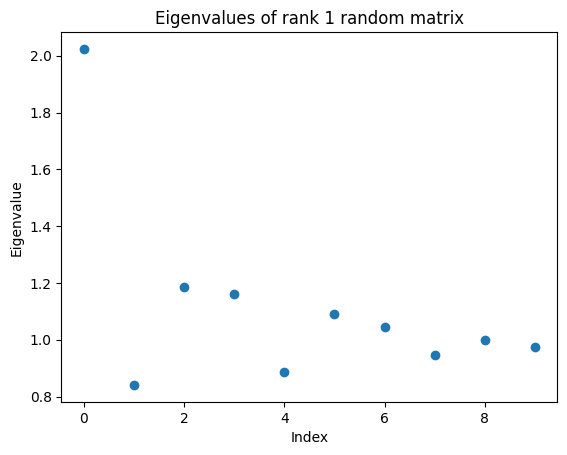

In [23]:
rank1_random_matrix = get_random_matrix_with_rank(size, 1, sigma)
rank1_cov= np.cov(rank1_random_matrix, rowvar=False)
rank1_eig_vals, rank1_eig_vecs = np.linalg.eig(rank1_cov)

import matplotlib.pyplot as plt
plt.plot(rank1_eig_vals, 'o')
plt.title('Eigenvalues of rank 1 random matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()


(b) rank=5. Plot the eigenvalues of the covariance matrix.

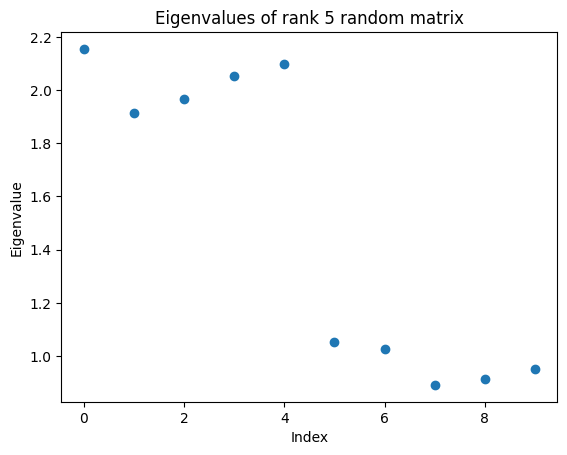

In [24]:
rank5_random_matrix = get_random_matrix_with_rank(size, 5, sigma)
rank5_cov= np.cov(rank5_random_matrix, rowvar=False)
rank5_eig_vals, rank5_eig_vecs = np.linalg.eig(rank5_cov)

import matplotlib.pyplot as plt
plt.plot(rank5_eig_vals, 'o')
plt.title('Eigenvalues of rank 5 random matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

(c) rank 10.Plot the eigenvalues of the covariance matrix.

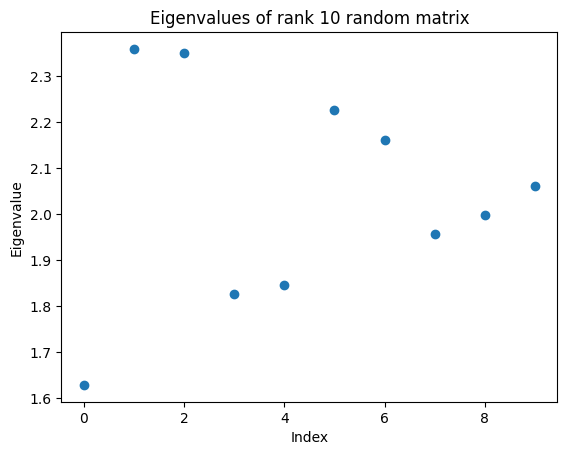

In [25]:
rank10_random_matrix = get_random_matrix_with_rank(size, 10, sigma)
rank10_cov= np.cov(rank10_random_matrix, rowvar=False)
rank10_eig_vals, rank10_eig_vecs = np.linalg.eig(rank10_cov)

import matplotlib.pyplot as plt
plt.plot(rank10_eig_vals, 'o')
plt.title('Eigenvalues of rank 10 random matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

(d) What pattern do you observe? How would you connect it to Markowitz’s
curse(Chapter 16)?

rank가 작을 수록 condition number가 큰 경향을 보인다.

이를 markowitz의 저주와 밀접하게 관련되어 있다. Markowitz의 mean-variance 최적화는 자산을 추가하면 이론적으로 더 높은 분산 효과를 기대할 수 있지만  
현실에서는 자산의 수익률의 상관관계가 높은 경우 공분산 행렬은 다중공선성 문제를 가지게 되고, 이로 인해 공분한 행렬의 condition number가 커져서, 역행렬 계산시 작은 추정 오류에도   
포트폴리오 비중이 급격히 변하는 불안정성이 발생합니다.  

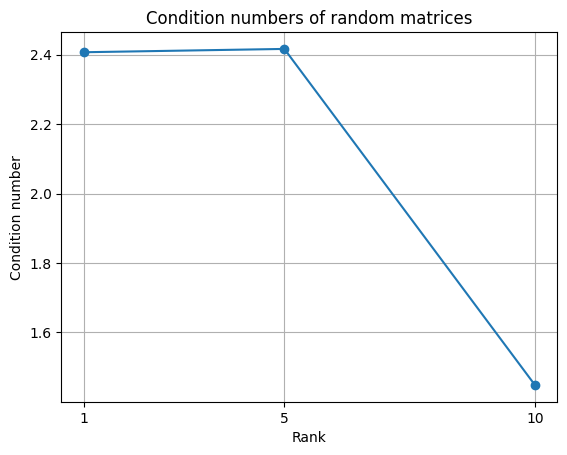

In [26]:
rank1_condition_number = np.linalg.cond(rank1_cov)
rank5_condition_number = np.linalg.cond(rank5_cov)
rank10_condition_number = np.linalg.cond(rank10_cov)

import matplotlib.pyplot as plt
plt.plot([1, 5, 10], [rank1_condition_number, rank5_condition_number, rank10_condition_number], 'o-')
plt.title('Condition numbers of random matrices')
plt.xlabel('Rank')
plt.ylabel('Condition number')
plt.xticks([1, 5, 10])
plt.grid()
plt.show()

21.3 Run the numerical example in Section 21.6:

In [46]:
import pandas as pd
from itertools import combinations_with_replacement, product

def get_random_problem_parameters(horizon: int, size: int, rank:int, cov_sample_size: int = 1000) -> List[dict]:
    def generate_mean(size: int):
        return_mean=np.random.normal(size=size)
        return return_mean
    
    params=[]
    for _ in range(horizon):
        x= get_random_matrix_with_rank((cov_sample_size, size), rank, 0)
        mean = generate_mean(size)  # [size,]
        cov= np.cov(x, rowvar=False)  # [size, size]
        scale=np.random.uniform(size=cov.shape[0])*np.diag(cov)**0.5 # [size,]
        params.append({'mean': mean, 'cov': cov, 'scale': scale})
    return params


def get_transaction_costs(weights: pd.DataFrame, params: List[dict]):
    """
    Calculate the transaction costs based on the portfolio weights and parameters.
    """
    cost=np.zeros(weights.shape[0])
    w_before=np.zeros(weights.shape[1])
    for i in range(weights.shape[0]):
        scale=params[i]['scale']
        cost[i]=(scale*np.sqrt(np.abs(weights.iloc[i] - w_before))).sum()
        w_before=weights.iloc[i]
    cost=pd.Series(cost, index=weights.index)
    cost.name = 'transaction_costs'
    return cost

def get_sharpe_ratio(weights:pd.DataFrame, params:List[dict], t_costs: pd.Series):
    """
    Calculate the Sharpe ratio based on the portfolio weights, parameters, and transaction costs.
    weights: pd.DataFrame - Portfolio weights for each horizon [N, M] where N is the number of horizons and M is the number of assets.
    """
    t_mean, t_cov=0, 0
    for i in range(weights.shape[0]):
        mean = params[i]['mean']
        cov = params[i]['cov']
        w = weights.iloc[i]
        
        # Calculate expected return and risk
        expected_return = np.dot(mean, w) # scalar
        risk = np.sqrt(np.dot(w.T, np.dot(cov, w))) # scalar
        
        # Adjust for transaction costs
        t_mean += expected_return - t_costs.iloc[i]
        
        t_cov+=risk
    return t_mean / t_cov if t_cov != 0 else 0

def get_static_optimal_portfolio(params: List[dict]) -> pd.DataFrame:
    """
    Calculate the static optimal portfolio based on the given parameters and risk aversion.
    """
    # Calculate the optimal portfolio weights
    weights=[]
    for param in params:
        mean = param['mean']
        cov = param['cov']

        # cal optimal portfolio weights (MV optimization)
        cov_inv = np.linalg.inv(cov)
        w=np.dot(cov_inv, mean) # [N, 1]
        w /= np.dot(np.dot(mean.T, cov_inv), mean)
        w/=abs(w).sum()

        weights.append(w)
    weights=pd.DataFrame(weights, columns=['weight_{}'.format(i) for i in range(len(weights[0]))], index=range(len(params)))
    t_cost= get_transaction_costs(weights, params)
    sharpe_ratio = get_sharpe_ratio(weights, params, t_cost)
    return sharpe_ratio, weights


def get_dynamic_optimal_portfolio(params: List[dict], k=None):
    
    """
    Calculate the dynamic optimal portfolio based on the given parameters
    """
    # Generate partitions
    if k is None:
        k=params[0]['mean'].shape[0]
    n=params[0]['mean'].shape[0] # number of assets
    def get_all_weights(k:int, n:int):
        def pigeon_hole(k:int, n:int):
            for j in combinations_with_replacement(range(n), k):
                r=[0]*n
                for i in j:
                    r[i]+=1
                yield r
        partitions=pigeon_hole(k, n)
        weights=[]
        for p in partitions:
            cur_w=np.array(p)/float(k)
            for prod in product([-1, 1], repeat=n):
                w=cur_w * prod # [N,]
                weights.append(w)
        weights=pd.DataFrame(weights, columns=['weight_{}'.format(i) for i in range(n)])
        return weights

    weights = get_all_weights(k, n) # [M, N] M: number of partitions, N: number of assets
    best_sharpe_ratio = -np.inf
    best_weights = None
    for p in product(weights.values, repeat=len(params)):
        p = pd.DataFrame(p, columns=weights.columns)
        p.index = range(len(params))
        sharpe_ratio = get_sharpe_ratio(p, params, get_transaction_costs(p, params))
        if best_sharpe_ratio < sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_weights = p
    return best_sharpe_ratio, best_weights

(a) Use size =3, and compute the running time with timeit. Repeat 10
batches of 100 executions. How long did it take?

In [48]:
params=get_random_problem_parameters(2, 3, 3, 1000)

import timeit

batch=10
static_time=0;
for _ in range(batch):
    static_time += timeit.timeit(lambda: get_static_optimal_portfolio(params), number=100)

dynamic_time=0;
for _ in range(batch):
    dynamic_time += timeit.timeit(lambda: get_dynamic_optimal_portfolio(params), number=100)

print("Static optimization time: {:.4f} seconds".format(static_time/ batch))
print("Dynamic optimization time: {:.4f} seconds".format(dynamic_time/ batch))

Static optimization time: 0.0335 seconds
Dynamic optimization time: 192.6656 seconds


(b) Use size =4,and timeit.Repeat 10 batches of 100 executions.How long
did it take?

In [49]:
params=get_random_problem_parameters(2, 4, 4, 1000)

import timeit

batch=10
static_time=0;
for _ in range(batch):
    static_time += timeit.timeit(lambda: get_static_optimal_portfolio(params), number=100)

dynamic_time=0;
for _ in range(batch):
    dynamic_time += timeit.timeit(lambda: get_dynamic_optimal_portfolio(params), number=100)

print("Static optimization time: {:.4f} seconds".format(static_time/ batch))
print("Dynamic optimization time: {:.4f} seconds".format(dynamic_time/ batch))

Static optimization time: 0.0327 seconds
Dynamic optimization time: 9090.1147 seconds


21.4 Review all snippets in this chapter.

(a) How many could be vectorized?

getAllWeights, evalSR, dynOptPort, params generation, static optimal portfoltio가 가능할 수 있다.

(b) How many could be parallelized, using the techniques from Chapter 20?

getAllWeights, evalSR, dynOptPort, params generation, static optimal portfoltio가 가능할 수 있다.

(c) If you optimize the code ,by how much do you think you could speed it up?

vector화 가능한 부분은 loop문 전체에 대해서 성능 향상이 가능하므로 input에 따라 다르지만 최소 5배~50배 개선이 가능할것 같고, 병렬화만 가능한 부분은 cpu의 수만큼이므로 이것도 5배이상 개선이 가능할거 같다.

(d) Using the optimized code, what is the problem dimensionality that could
be solved with in a year?

21.5 Under what circumstances would the globally dynamic optimal trajectory match
the sequence of local optima?

1. 시점별로 이동하여도 거래비용이 발생하지 않는다, 2. 전체목적함수가 시점별의 합이다, 3. 목표가 path-independent할때

(a) Is that a realistic set of assumptions?

현실적이지 않은 가정이다.

(b) If not, could that explain why naıve solutions beat Markowitz’s(Chapter16)?

Markowitz’s는 local optimal를 구하는 것이므로 naive solution이 markowitz보다 성능이 좋다.


(c) why do you think so many firms spend so much effort in computing
sequences of local optima?

local optimum만 계산하면 되므로 연산이 용이하고, 직관에 가까운 방식이기 때문에 해석이 용이하기 때문이다.